# Benchmarking notebook

This notebook contains all of the methods and analysis for performing benchmarking

# Imports and dependencies

In [1]:
import os
import glob
from pathlib import Path
from enum import Enum
import numpy as np
from dataclasses import dataclass
from typing import List, Dict
import matplotlib.pyplot as plt
import pickle
import json

# Notebook parameters
These parameters are used throughout the notebook for benchmarking. These parameters include paths, tuning, and other various parameter settings.

In [2]:
file_with_names = "./abundance.tsv"
accession2taxid_file = "../../database/krakenDB/taxonomy/nucl_gb.accession2taxid"


In [3]:
# read in the NCBI to Tax id namings
with open('out_dictionary.txt') as f:
    dictionary_str = f.read()
dictionary = json.loads(dictionary_str)

### create mapping dictionary (don't need to run, done offline and included)
This step is time consuminig so better done offline

**NOTE**: This is skipped assuming the above works

In [43]:
def get_needed_ncbi_ids():
    """
    gets NCBI ids
    """
    file_with_names_opened = open(file_with_names)
    
    # grab all needed NCBI ids
    ncbi_ids = []
    line = file_with_names_opened.readline()
    line_counter = 0
    while(line):
        if (line_counter > 0): # skip header
            ncbi_id = line.split("\t")[0]
            ncbi_ids.append(ncbi_id)
        line = file_with_names_opened.readline()
        line_counter += 1
        
    file_with_names_opened.close()
    
    return ncbi_ids

In [44]:
def create_mapping_dictionary():
    """
    Creates dictionary for mapping NCBI ids to 
    taxonomy.
    
    Uses nucl_gb.accession2taxid
    
    NC_033618	NC_033618.1	1931113	1139918407
    """
    dictionary = {}

    # grab taxid mappings
    acc2tax_open = open(accession2taxid_file)
    line = acc2tax_open.readline()
    counter = 0
    while(line):
        line = acc2tax_open.readline()
        line = line.split("\t")
        accession = line[1]
        taxid = line[2]
        if accession in ncbi_ids:
            dictionary[accession] = taxid
        if (len(dictionary.keys()) == len(ncbi_ids)):
            break
        counter += 1
        
        if (counter % 100000 == 0):
            print(f"{counter} lines have been parsed \n")
    acc2tax_open.close()

    return dictionary

if not dictionary:
    ncbi_ids = get_needed_ncbi_ids()
    dictionary = create_mapping_dictionary()

# Parsers
These methods are used for parsing all of the tools being benchmarked. These parsers are passed to a general parser function, giving a strategy-pattern-like method for obtaining result from tools.

In [4]:
def parser_enrichseq(enrichseq_dir: Path, delim=","):
    """
    Description
    -----------
        This function parses the enrichseq output directory.
        
    Input
    -----------
        1. Path to a singular EnrichSeq output directory.
        2. [optional; Def=','] - delimiter
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
            2. cluster abundances
            abundances_dict = {'cluster_1' : 33,
                               'cluster_2' : 33,
                               ...,
                               'cluster_M' : 33,
                              }
    """
    # nested dictionary of different abundance measurements
    abundances = {"taxid_abundance" : {},"cluster_abundance" : {}} 
    # get paths
    output_path = enrichseq_dir / Path('enrichseq/output_files/')
    taxid_abundances_path = output_path / Path('taxid_abundances.csv')
    cluster_abundances_path = output_path / Path('cluster_abundances.csv')
    csvs_to_parse = {"taxid_abundance" : taxid_abundances_path, 
                     "cluster_abundance" : cluster_abundances_path}
    # parse abundance CSVs
    for csv_name, csv_file in csvs_to_parse.items():
        with open(csv_file, "r") as csv_file_opened:
            csv_file_lines = csv_file_opened.readlines() # never that big, read all into RAM
            for line in csv_file_lines:
                tax_clust_id, abundance_val = line.strip("\n").split(delim)
                abundances[csv_name][tax_clust_id] = float(abundance_val)

    return abundances

def parser_fastviromeexplorer(directory, name_column=0, counts_column=3, delim="\t"):
    """                          
    Description
    -----------
        This function parses the FastViromeExplorer output directory.
        
    Input
    -----------
        1. Path to a singular FastViromeExplorer output directory.
        2. column index corresponding to NCBI id
        3. column index corresponding to the read counts
        4. [optional; Def='\t'] - delimiter
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
    """
    # init datastructures
    abundances = {"taxid_abundance" : {}} # <tax/clust>id : abundance
    # get paths
    taxid_abundances = directory / Path('abundance.tsv')
    # parse abundance CSVs
    csvs_to_parse = {"taxid_abundance" : taxid_abundances}
    total_abundance = 0
    for csv_name, csv_file in csvs_to_parse.items():
        with open(csv_file, "r") as csv_file_opened:
            csv_file_lines = csv_file_opened.readlines() # never that big, read all into RAM
            for line_ind, line in enumerate(csv_file_lines):
                if line_ind > 0: # skip header
                    ncbi_id = line.strip("\n").split(delim)[name_column]
                    counts_val = line.strip("\n").split(delim)[counts_column]

                    # convert NCBI name to taxid, save counts
                    if ncbi_id in dictionary:
                        tax_clust_id = dictionary[ncbi_id] # 'dictionary' imported above
                    else:
                        tax_clust_id = 'unk'
                    abundances[csv_name][tax_clust_id] = float(counts_val)
                    total_abundance += float(counts_val)
    
    # update abundances dictionary
    ids_to_del = []
    for tax_id, abundance_val in abundances["taxid_abundance"].items():
        if total_abundance > 0:
            abundances["taxid_abundance"][tax_id] /= total_abundance #normalize
        if abundances["taxid_abundance"][tax_id] < 0.001:
            ids_to_del.append(tax_id)
    # delete 0 value taxids
    for val in ids_to_del:
        del abundances["taxid_abundance"][val]

    return abundances

def parse_simulated_fasta(fasta_path):
    """                          
    Description
    -----------
        This function parses the simulated true fasta file used
        for testing.
        
    Input
    -----------
        1. Path to a singular simulated fasta file
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
    """
    abundances = {'taxid_abundance' : {}}
    total_counts = 0
    with open(fasta_path, "r") as fasta_opened:
        line = fasta_opened.readline()
        while (line):
            if (line[0] == ">"):
                ncbi_id = line[1:].split("|")[0].split("-")[0]
                # dictioinary from FastViromeExplorer, obtained above
                if ncbi_id in dictionary:
                    name = dictionary[line[1:].split("|")[0].split("-")[0]]
                else:
                    name = "unk"
                # increment abundance level per read count
                if name in abundances['taxid_abundance']:
                    abundances['taxid_abundance'][name] += 1
                else:
                    abundances['taxid_abundance'][name] = 1
                total_counts += 1
                # print update
                if (total_counts % 1000000 == 0):
                    print(f"{total_counts} lines parsed")
            line = fasta_opened.readline()
            
    #turn counts into abundances - normalize
    for tax_id in abundances['taxid_abundance'].keys():
        abundances['taxid_abundance'][tax_id] /= total_counts #normalize
    return abundances

## Kraken2 and Bracken Parsers

In [5]:
def parser_bracken(directory, taxid_column=1, abundance_column=6, delim="\t"):
    """
    Description
    -----------
        This function parses the enrichseq output directory.
        
    Input
    -----------
        1. Path to a singular Bracken output directory.
        2. [optional; Def='\t'] - delimiter
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
    """
    # dictionary of bracken abundance 
    abundances = {'taxid_abundance' : {}}
    # get paths
    taxid_abundances = directory / Path('abundances.bracken')
    
    files_to_parse = {"taxid_abundance" : taxid_abundances}
    
    # parse bracken abundance files
    for file_name, bracken_file in files_to_parse.items():
        with open(bracken_file, "r") as bracken_file_opened:
            bracken_file_lines = bracken_file_opened.readlines() # never that big, read all into RAM
            for line_ind, line in enumerate(bracken_file_lines):
                if line_ind > 0: # skip header
#                     ncbi_id = line.strip("\n").split(delim)[name_column]
#                     counts_val = line.strip("\n").split(delim)[counts_column]
                    tax_id = line.strip("\n").split(delim)[taxid_column]
                    abundance_val = line.strip("\n").split(delim)[abundance_column]
                    abundances[file_name][tax_id] = float(abundance_val)
    
    # update abundances dictionary
    ids_to_del = []
    for tax_id, abundance_val in abundances["taxid_abundance"].items():
        if abundances["taxid_abundance"][tax_id] < 0.001:
            ids_to_del.append(tax_id)
    # delete 0 value taxids
    for val in ids_to_del:
        del abundances["taxid_abundance"][val]

    return abundances

## Testing parsing functions using old directory structure

In [7]:
# testing parsing functions

# Paths
fastvirome_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/results/FastViromeExplorer/num_mutations_test/3_genomes_sim_05del_0ins_illumina/"
enrichseq_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/results/enrichseq/num_mutations_test/3_genomes_sim_05del_0ins_illumina./"
truth_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/tests/num_mutations_test/3_genomes_sim_05del_0ins_illumina.fa"
# run tests
fastvirome_values = parser_fastviromeexplorer(fastvirome_test_dir)
enrichseq_values = parser_enrichseq(enrichseq_test_dir)
true_values = parse_simulated_fasta(truth_test_dir)
print(fastvirome_values)
print(enrichseq_values)
print(true_values)

{'taxid_abundance': {'2681618': 0.330471010766504, '10868': 0.3341472256116903, '2886930': 0.331408347698171}}
{'taxid_abundance': {'2886930': 0.322980298029803, 'UNK': 0.031225122512251225, '10868': 0.3230953095309531, '2681618': 0.3226992699269927}, 'cluster_abundance': {'C_2': 0.322980298029803, 'UNK': 0.031225122512251225, 'C_1': 0.3230953095309531, 'C_3': 0.3226992699269927}}
{'taxid_abundance': {'2886930': 0.5601445317423638, '10868': 0.4398554682576362}}


In [8]:
# testing bracken parser

bracken_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/results/Bracken/num_genomes_test/5_genomes_sim_illumina/"
bracken_values = parser_bracken(bracken_test_dir)
print(bracken_values)

{'taxid_abundance': {'10658': 0.19845, '10742': 0.25694, '1977411': 0.23527, '2011076': 0.29346, '562': 0.0045, '28901': 0.00211}}


## Testing parsing functions using new directory structure 
(with "test_1", "test_2", etc)

**Parser functions work**

In [13]:
enrichseq_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/results3/EnrichSeq/test_1/num_reads_200genomes/200_genomes_500000_reads/"
bracken_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/results3/Bracken/test_2/num_genomes/200_genomes_500000_reads"
truth_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/tests/test_1/num_reads_200genomes/200_genomes_500000_reads.fa"

enrichseq_values = parser_enrichseq(enrichseq_test_dir)
bracken_values = parser_bracken(bracken_test_dir)
true_values = parse_simulated_fasta(truth_test_dir)

print(enrichseq_values)
print(bracken_values)
print(true_values)

{'taxid_abundance': {'1162290': 0.004962, 'UNK': 0.056458, '446529': 0.00497, '929814': 0.005052, '753085': 0.004948, '2163591': 0.007778, '2079565': 0.010654, '2653759': 0.011978, '2776877': 0.003134, '1792253': 0.004894, '1815972': 0.006996, '1458726': 0.004364, '1076630': 0.004216, '2015873': 0.004952, '1486426': 0.005136, '2301539': 0.004964, '2282909': 0.004056, '2530128': 0.000518, '1150992': 0.004938, '2653274': 0.010058, '2250417': 0.00924, '2024320': 0.003712, '1815590': 0.018, '1701812': 0.004956, '157924': 0.004978, '537874': 0.004962, '2517969': 0.004964, '1897767': 0.004752, '1805956': 0.004974, '584892': 0.004972, '2750850': 0.001524, '2716728': 0.00142, '1348912': 0.004972, '313629': 0.00289, '2488980': 0.001824, '2517966': 0.000482, '1536603': 0.0009, '148603': 0.001928, '2099449': 0.009848, '1173762': 0.004842, '1973454': 0.005084, '2652415': 0.004966, '2052752': 0.004956, '2301650': 0.00773, '1852630': 0.002204, '1871690': 0.00496, '1325372': 0.00496, '1965368': 0.004

# Results Methods and structures
The methods and data structures here are used for creating a common data structure for the output of all tools being compared with one another. 

In [6]:
class ResultStruct:
    """ EnrichSeq - datastruct for holding results """
    
    def __init__(self):
        self.l2_abundance_distance = []
        self.classification_recall = 0
        self.classification_precision = 0

In [7]:

"""
Name of each key in PARSERS_MAP 
must correspond to directory name.
"""
PARSERS_MAP = {"EnrichSeq" : parser_enrichseq,
               "FastViromeExplorer" : parser_fastviromeexplorer,
               "Bracken": parser_bracken,
               "truth" : parse_simulated_fasta}

def parse_dir(results_directory, test_directory, parsers=PARSERS_MAP):
    """                          
    Description
    -----------
        This function parses all of the result directories including
        the test directory and returns a data structure containing the results.
        
    Input
    -----------
        1. Path to a singular simulated fasta file
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
    """
    results = {}
    # parse truth
    results = parse_true_directory(test_directory, results, parsers)
    # parse results
    results = parse_tools(results_directory, results, parsers)
    # create results from parsed information
    results = parsed_dict_to_results(results)
    
    return results
    
def parse_true_directory(test_directory, results: Dict, parsers):
    """                          
    Description
    -----------
        This function parses the truth directory, adding the parsed 
        abundance results to input results dictionary.
        
                    TEST
                      |
                    /   \
                TEST_1    TEST_2
               /   |        |    \
       test-1.a test-1.b test-2.a test-2.b
       
                    into 
                       
                   Results (a dictionary)
                      |
                    /   \
             "TEST_1"    "TEST_2"
               /   |        |    \
    trueAb-1.a trueAb-1.b trueAb-2.a trueAb-2.b
         
    Input
    -----------
        1. Path to a the entire truth test directory
        2. results dictionary
        3. parsers
        
    Output
    -----------
        results dictionary with the true abundance values added:
        
        example:
        'num_genomes_test': {
                             '5_genomes_sim_illumina': {'true': 
                                  {'taxid_abundance': {'2886930': 0.2, 
                                                       '10868': 0.2, 
                                                       '2681618': 0.2, 
                                                       '10658': 0.2, 
                                                       '127507': 0.2}
                                  }
                             },
    """
    # parse truth
    for test_directory_name in os.listdir(test_directory):
        test_num_path = Path(test_directory) / Path(test_directory_name)
        for subtest_directory in os.listdir(test_num_path):
            test_full_path = Path(test_num_path) / Path(subtest_directory)
            if os.path.isdir(test_full_path): # if directory
                # create sub dictionary if not exists
                if test_directory_name not in results: results[test_directory_name] = {}
                if subtest_directory not in results[test_directory_name]: results[test_directory_name][subtest_directory] = {}

                # loop through all fasta files and parse for true abundance
                for file_test in os.listdir(test_full_path):
                    file_full_path = Path(test_full_path) / Path(file_test)
                    if os.path.isfile(file_full_path) and (file_full_path.suffix == ".fa"): # if file and fasta
                        # create subsub dictionary if not exists
                        if file_test not in results[test_directory_name][subtest_directory]:
                            file_test = file_test.replace(".fa", "")
                            results[test_directory_name][subtest_directory][file_test] = {}

                        # add abundances to results
                        abundances = parsers["truth"](file_full_path)
                        # print(f'Truth: {abundances}') # PRINTS CORRECTLY
                        results[test_directory_name][subtest_directory][file_test]["true"] = abundances
                        # print(results[test_directory_name][subtest_directory][file_test]["true"]) # THIS WORKS
    return results
                 
    
def parse_tools(results_directory, results: Dict, parsers):
    """                          
    Description
    -----------
        This function parses the results directory, adding the 
        parsed abundances results to input results dictionary.  
         
    Input
    -----------
        1. Path to a the entire benchmarking results directory
        2. results dictionary
        3. parsers
        
    Output
    -----------
        results dictionary with the tool prediction abundances 
        values added.
        
        example:
        'num_genomes_test': {
                             '5_genomes_sim_illumina': {tool_X': 
                                  {'taxid_abundance': {'2886930': 0.2, 
                                                       '10868': 0.2, 
                                                       '2681618': 0.2, 
                                                       '10658': 0.2, 
                                                       '127507': 0.2}
                                  }
                             },
    """
    for tool_name in os.listdir(results_directory):
        print(tool_name)
        results_path = Path(results_directory) / Path(tool_name)
        for test_directory_name in os.listdir(results_path): # e.g. [test_1, test_2, test_3]
            test_num_path = Path(results_path) / Path(test_directory_name)
            for subtest_directory in os.listdir(test_num_path): # e.g. [num_genomes, num_reads]
                test_type_path = Path(test_num_path) / Path(subtest_directory)
                for final_test_directory in os.listdir(test_type_path): # e.g. [200_genomes_500k_reads]
                    test_full_path = Path(test_type_path) / Path(final_test_directory)
                    if os.path.isdir(test_full_path): # if directory
                        # loop through all fasta files and parse for true abundance           
                        try:
                            #file_full_path must be tool/test_1/num_genome/subtest_dir
                            abundances = parsers[tool_name](test_full_path) 
                            # add abundances to results
                            results[test_directory_name][subtest_directory][final_test_directory.strip(".")][tool_name] = abundances
                            #print(results[test_directory_name][subtest_directory][final_test_directory.strip(".")].keys())
                        except:
                            print(f"{tool_name} is missing {final_test_directory} from {subtest_directory}, {test_directory_name}")
                            print(f"OR {tool_name} has a file that true doesn't have. Should be fine.")
                            continue
    return results

# TODO: FIX THIS
def parsed_dict_to_results(results):
    """                          
    Description
    -----------
        This function parses the parsed results dictionary,
        and creates a dictionary with all of the correct results.
        Overall this utilizes the results structure.
         
    Input
    -----------
        1. Path to a results dictionary containing truth and 
           tool predictions
        
    Output
    -----------
        1. results dictionary with the tool results.
    """
    
    for test_num in results.keys(): # is test_1, test_2
        for test_name in results[test_num].keys(): # is num_genomes, num_reads
            for sub_test in results[test_num][test_name].keys():
                for tool_name, result_val in results[test_num][test_name][sub_test].items():
                    if tool_name != "true":
                        results_out = get_results(results[test_num][test_name][sub_test][tool_name], 
                                              results[test_num][test_name][sub_test]["true"])
                        results[test_num][test_name][sub_test][tool_name] = results_out
                del results[test_num][test_name][sub_test]["true"]
    return results

def get_results(predicted_results, true_results):
    """                          
    Description
    -----------
        Given the true results and tool results, this
        function returns a Result Struct for a given tool.
        
    **NOTE**: This is where all of the metrics are calculated
              so this is the most important function for the 
              benchmarking - contains the logic.
         
    Input
    -----------
        1. dictionary of predicted results
        2. dictionary of true results
        
    Output
    -----------
        1. ResultStruct() with the tool results.
    """
    # init
    results_structure = ResultStruct()
    predicted_abundances = predicted_results['taxid_abundance']
    true_abundances = true_results['taxid_abundance']
    
    # error handling
    if (len(true_abundances) == 0): 
        print(f"TRUTH EMPTY")
        return results_structure
    
    # classification results
    ## true positives
    true_positives = []
    for pred_taxid in predicted_abundances.keys():
        if pred_taxid in true_abundances.keys():
            true_positives.append(pred_taxid)
    ## false positives
    false_positives = []
    for pred_taxid in predicted_abundances.keys():
        if (pred_taxid not in true_abundances.keys()) and (pred_taxid != "UNK"):
            false_positives.append(pred_taxid)
    ## false negatives
    false_negatives = []
    for pred_taxid in true_abundances.keys():
        if pred_taxid not in predicted_abundances.keys():
            false_negatives.append(pred_taxid)
            
    ## get metrics
#     print(f"predicted_abundances = {predicted_abundances}, true abundaces = {true_abundances}")
    recall = len(true_positives) / (len(true_positives) + len(false_negatives))
    precision = len(true_positives) / (len(true_positives) + len(false_positives))
    #print(f"recall : {recall} | precision : {precision}")
    
    # abundance results
    ## L2 distances
    l2_dist_array = []
    total_abundance_wo_unk = sum([abundance for key, abundance in predicted_abundances.items() if key != "UNK" ])
    for tax_id, pred_abundance in predicted_abundances.items():
        if tax_id in true_abundances:
            pred_abundance /= total_abundance_wo_unk
            l2_diff = abs(pred_abundance - true_abundances[tax_id])
        else:
            l2_diff = 0
        l2_dist_array.append(l2_diff)
    
    # store into results structure
    results_structure.l2_abundance_distance = l2_dist_array
    results_structure.classification_recall = recall
    results_structure.classification_precision = precision
    #print(results_structure.classification_precision)
    
    return results_structure

In [8]:
# create 'results'
results = parse_dir("//scratch/summit/dral3008/benchmarking_enrichseq/results3/",
                    "//scratch/summit/dral3008/benchmarking_enrichseq/tests/")

1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
FastViromeExplorer
FastViromeExplorer is missing 800_genomes_500000_reads from num_genomes, test_2
OR FastViromeExplorer has a file that true doesn't have. Should be fine.
EnrichSeq
Bracken


In [18]:

print(results['test_1']['num_genomes']['200_genomes_500000_reads']['Bracken'].classification_precision)



0.38509316770186336


# Plotting Methods
These methods use the common `ResultStruct` datastructure (or arry thereof) for plotting individual tool metrics. 

In [11]:
def plot_barplot(input_results, test, metric='classification'):                                                        
    """                                                                         
    This function plots a bar plot output for a given test set and value
    """ 
    
    width = 0.35
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    if (metric == 'classification'):
        sub_results = input_results[test]
        x_tick_names = [[], [], []]
        x_tick_arr = []
        index_map = {'EnrichSeq' : 0, 'FastViromeExplorer' : 1, 'Bracken' : 2}
        for subtest_name in sub_results.keys():
            x_tick_arr.append(" ".join(subtest_name.split("_")))
            for tool, results_struct in sub_results[subtest_name].items():
#                 print(f"{tool} Recall: {results_struct.classification_recall}")
#                 print(f"{tool} Precision: {results_struct.classification_precision}")
                f1_score = 2 * (results_struct.classification_recall * results_struct.classification_precision) 
                if ((results_struct.classification_recall != 0) or
                    (results_struct.classification_precision != 0)):
                    f1_score /= (results_struct.classification_recall + results_struct.classification_precision) 
                x_tick_names[index_map[tool]].append(f1_score)
#                 print(f"\n {subtest_name}")
#                 print(f"{tool} F1 Score: {results_struct.classification_precision}")
                
        # make plot
        ind = np.arange(len(x_tick_names[0]))
        ax.bar(ind, x_tick_names[index_map['EnrichSeq']], color='m', width = 0.30)
        
        if (len(x_tick_names[0]) == len(x_tick_names[1])):
            ax.bar(ind + 0.30, x_tick_names[index_map['FastViromeExplorer']], width = 0.30, color='b')
        
        if (len(x_tick_names[0]) == len(x_tick_names[2])):
            ax.bar(ind + 0.30, x_tick_names[index_map['Bracken']], width = 0.30, color='y')

        ax.legend(labels=['EnrichSeq', 'FastViromeExplorer', 'Bracken'])
        ax.set_xticks(ind + 0.25)
        ax.set_xticklabels(x_tick_arr, rotation=90)
        ax.set_title(f"Testing the impact of {test} \n {metric}-focused", size=15)
        ax.set_ylabel("F1 score", size=15)
        ax.set_xlabel("Sub test", size=15)
        
        
    elif (metric == 'abundance'):
        sub_results = input_results[test]
        x_tick_names = [[], [], []]
        x_tick_arr = []
        index_map = {'EnrichSeq' : 0, 'FastViromeExplorer' : 1, 'Bracken': 2}
        for subtest_name in sub_results.keys():
            x_tick_arr.append(" ".join(subtest_name.split("_")))
            for tool, results_struct in sub_results[subtest_name].items():
                l2_avg = np.average(results_struct.l2_abundance_distance)
                x_tick_names[index_map[tool]].append(l2_avg)
                
        # make plot
        ind = np.arange(len(x_tick_names[0]))
        ax.bar(ind, x_tick_names[index_map['EnrichSeq']], color='m', width = 0.30)
        if (len(x_tick_names[0]) == len(x_tick_names[1])):
            ax.bar(ind + 0.30, x_tick_names[index_map['FastViromeExplorer']], width = 0.30, color='b')
        
        if (len(x_tick_names[0]) == len(x_tick_names[2])):
            ax.bar(ind + 0.30, x_tick_names[index_map['Bracken']], width = 0.30, color='y')
        ax.legend(labels=['EnrichSeq', 'FastViromeExplorer', 'Bracken'])
        ax.set_xticks(ind + 0.25)
        ax.set_xticklabels(x_tick_arr, rotation=90)
        ax.set_title(f"Testing the impact of {test} \n {metric}-focused", size=15)
        ax.set_ylabel("L2 distance", size=15)
        ax.set_xlabel("Sub test", size=15)
    else:
        print(f"Metric of type {metric} is not known")
    plt.show()

In [11]:
def print_results(input_results):                                                        
    """                                                                         
    This function prints the results in a hierarchical structure
    """ 
    for test in input_results.keys():
        print(f"\n {test}")
        sub_results = input_results[test]
        for subtest_name in sub_results.keys():
            print(f"\t {subtest_name}")
            for tool, results_struct in sub_results[subtest_name].items():
                print(f"\t\t {tool}")
                print(f"\t\t\t L2-avg: {np.average(results_struct.l2_abundance_distance)}")
                print(f"\t\t\t recall: {results_struct.classification_recall}")
                print(f"\t\t\t precision: {results_struct.classification_precision}")

# Benchmarking
This section splits the various benchmarking sections into a clear, concise set of scripts.

### Number of genomes comparison

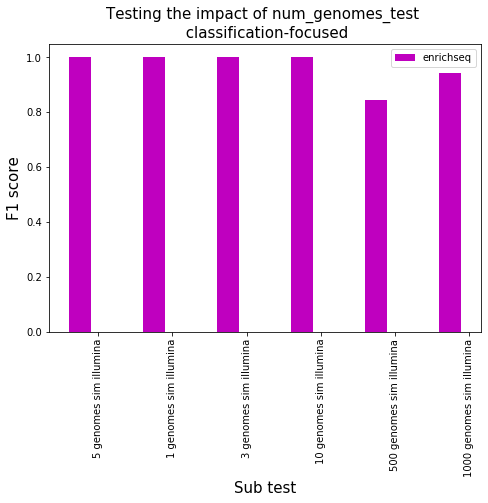

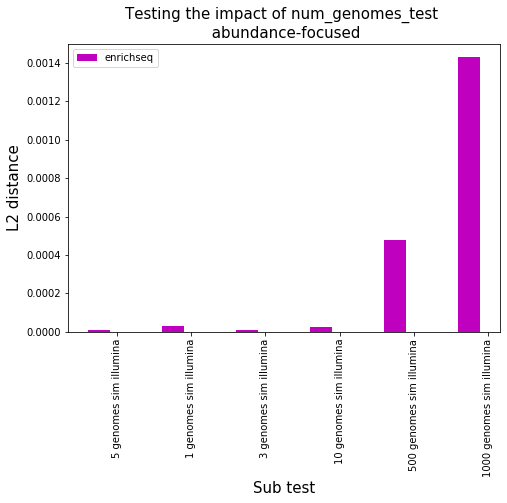

{'5_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b8d137f9908>,
  'Bracken': <__main__.ResultStruct at 0x2b8d137e5160>},
 '1_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b8d13826208>,
  'Bracken': <__main__.ResultStruct at 0x2b8d138137f0>},
 '3_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b8d137f99e8>,
  'Bracken': <__main__.ResultStruct at 0x2b8d137f99b0>},
 '10_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b8d137f9978>,
  'Bracken': <__main__.ResultStruct at 0x2b8d137e5128>},
 '500_genomes_sim_illumina': {'Bracken': <__main__.ResultStruct at 0x2b8d13821400>},
 '1000_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b8d13821978>,
  'Bracken': <__main__.ResultStruct at 0x2b8d13813fd0>},
 '100_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b8d13813f98>,
  'Bracken': <__main__.ResultStruct at 0x2b8d137e5f98>}}

In [15]:
plot_barplot(results, test='num_genomes_test', metric='classification')
plot_barplot(results, test='num_genomes_test', metric='abundance')

results['num_genomes_test']

### Number of read mutations

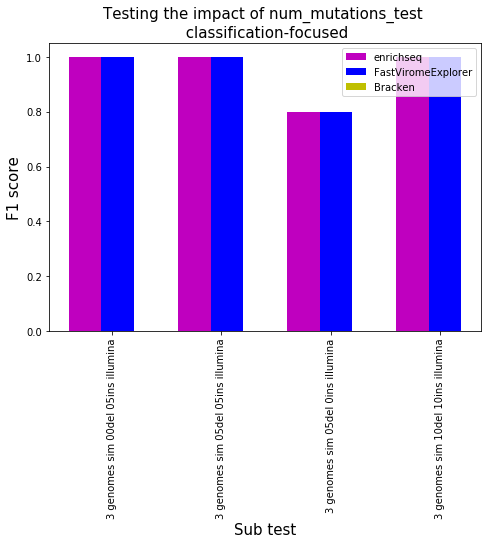

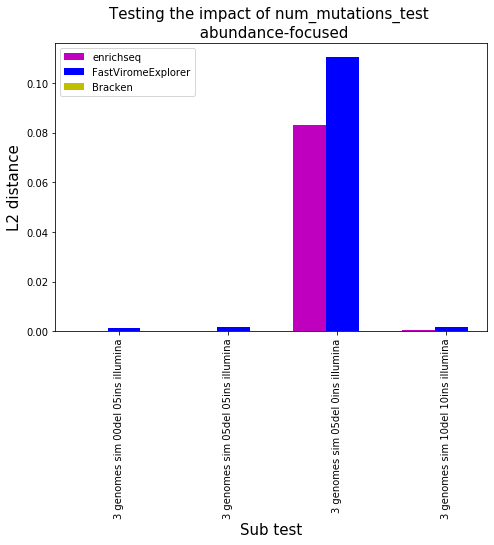

{'3_genomes_sim_00del_05ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct at 0x2b8d137e5fd0>,
  'enrichseq': <__main__.ResultStruct at 0x2b8d137e5f60>,
  'Bracken': <__main__.ResultStruct at 0x2b8d137e5f28>},
 '3_genomes_sim_05del_05ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct at 0x2b8d137e5ef0>,
  'enrichseq': <__main__.ResultStruct at 0x2b8d137e5eb8>,
  'Bracken': <__main__.ResultStruct at 0x2b8d137e5e80>},
 '3_genomes_sim_05del_0ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct at 0x2b8d137e5e48>,
  'enrichseq': <__main__.ResultStruct at 0x2b8d137e5dd8>,
  'Bracken': <__main__.ResultStruct at 0x2b8d137e5e10>},
 '3_genomes_sim_10del_10ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct at 0x2b8d137e5da0>,
  'enrichseq': <__main__.ResultStruct at 0x2b8d137e5d30>,
  'Bracken': <__main__.ResultStruct at 0x2b8d137e5d68>}}

In [16]:
plot_barplot(results, test='num_mutations_test', metric='classification')
plot_barplot(results, test='num_mutations_test', metric='abundance')

results['num_mutations_test']

### Number of reads

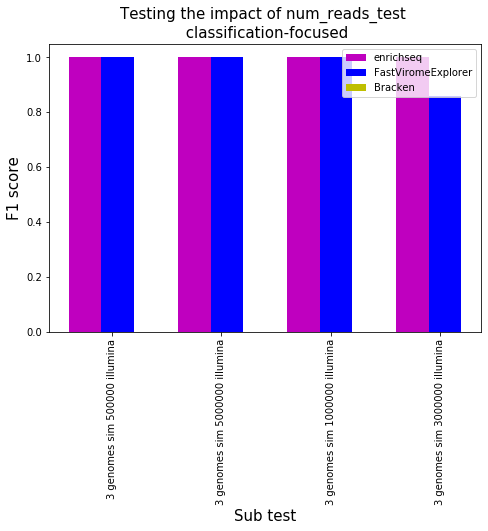

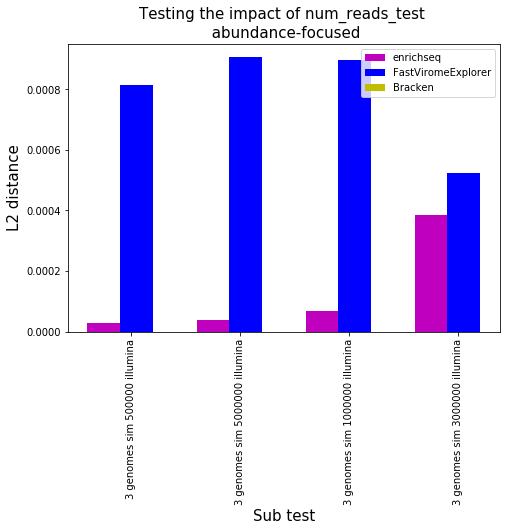

In [17]:
plot_barplot(results, test='num_reads_test', metric='classification')
plot_barplot(results, test='num_reads_test', metric='abundance')


# Plotting using Seaborn

In [11]:
import seaborn as sns
import pandas as pd


### TESTING ###
# long_df = pd.DataFrame({'Number of Genomes': ['10','10','10','200','200','200','400','400','400'],
#                        'Tool': ['EnrichSeq', 'FastViromeExplorer','Bracken', 
#                                'EnrichSeq', 'FastViromeExplorer','Bracken',
#                                'EnrichSeq', 'FastViromeExplorer','Bracken'],
#                        'F1 Score': [1.0, 1.0, 0.7, 0.95, 0.91, 0.6, 0.9, 0.75, 0.5]})

# sns.catplot(x="Number of Genomes", y="F1 Score", hue="Tool", kind="bar", data=long_df)

#################

def plot_bar_classification(input_results, test='num_genomes'):
    """
    Input
    --------
    results dictionary in the form 
        results['test_1']['num_genomes']['200_genomes_500000_reads']['Bracken'] = ResultStruct object
    
    Output
    --------
    None, displays a plot
    """
    plotting_dict = {'Number of Genomes': [], 'Tool': [], 'F1 Score': []}
    for xval in input_results['test_1'][test].keys():
        for tool,result_struct in input_results['test_1'][test][xval].items():
            # xval should be added 3 times, once for every tool
            plotting_dict['Number of Genomes'].append(xval) # TODO: Extract just the number?
            plotting_dict['Tool'].append(tool)
            f1_score = 2 * (result_struct.classification_recall * result_struct.classification_precision) 
            if ((result_struct.classification_recall != 0) or
                    (result_struct.classification_precision != 0)):
                    f1_score /= (result_struct.classification_recall + result_struct.classification_precision)
            plotting_dict['F1 Score'].append(f1_score)
            print(f'# Genomes: {xval}, Tool: {tool}')
            print(f'precision = {result_struct.classification_precision}, recall = {result_struct.classification_recall}')

    test_df = pd.DataFrame.from_dict(plotting_dict)
    plot = sns.catplot(x="Number of Genomes", y="F1 Score", hue="Tool", kind="bar", data=test_df)
    for axes in plot.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    

def plot_bar_abundance(input_results, test='num_genomes'):
    """
    Input
    --------
    results dictionary in the form 
        results['test_1']['num_genomes']['200_genomes_500000_reads']['Bracken'] = ResultStruct object
    
    Output
    --------
    None, displays a plot
    """
    plotting_dict = {'Number of Genomes': [], 'Tool': [], 'F1 Score': []}
    for xval in input_results['test_3'][test].keys():
        for tool,result_struct in input_results['test_3'][test][xval].items():
            # xval should be added 3 times, once for every tool
            plotting_dict['Number of Genomes'].append(xval) # TODO: Extract just the number?
            plotting_dict['Tool'].append(tool)
            f1_score = 2 * (result_struct.classification_recall * result_struct.classification_precision) 
            if ((result_struct.classification_recall != 0) or
                    (result_struct.classification_precision != 0)):
                    f1_score /= (result_struct.classification_recall + result_struct.classification_precision)
            plotting_dict['F1 Score'].append(f1_score)

    test_df = pd.DataFrame.from_dict(plotting_dict)
    plot = sns.catplot(x="Number of Genomes", y="F1 Score", hue="Tool", kind="bar", data=test_df)
    for axes in plot.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

# Genomes: 800_genomes_500000_reads, Tool: FastViromeExplorer
precision = 0.8333333333333334, recall = 0.9946236559139785
# Genomes: 800_genomes_500000_reads, Tool: EnrichSeq
precision = 0.41517857142857145, recall = 0.75
# Genomes: 800_genomes_500000_reads, Tool: Bracken
precision = 0.5333333333333333, recall = 0.6021505376344086
# Genomes: 200_genomes_500000_reads, Tool: FastViromeExplorer
precision = 0.6227544910179641, recall = 0.9904761904761905
# Genomes: 200_genomes_500000_reads, Tool: EnrichSeq
precision = 0.38524590163934425, recall = 0.8952380952380953
# Genomes: 200_genomes_500000_reads, Tool: Bracken
precision = 0.38509316770186336, recall = 0.5904761904761905
# Genomes: 400_genomes_500000_reads, Tool: FastViromeExplorer
precision = 0.6765799256505576, recall = 0.994535519125683
# Genomes: 400_genomes_500000_reads, Tool: EnrichSeq
precision = 0.37371134020618557, recall = 0.7923497267759563
# Genomes: 400_genomes_500000_reads, Tool: Bracken
precision = 0.40304182509505704, 

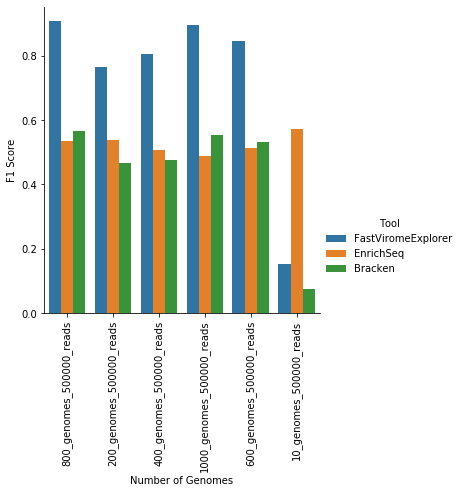

In [12]:
plot_bar_classification(results)
#plot_bar_abundance(results)

# Plotting using Altair
1. Set up dummy data to test long-form format compatible with altair
2. Create function for bar plot

In [10]:
import pandas as pd
import numpy as np
import altair as alt
test_results = pd.DataFrame({'tool': ['EnrichSeq', 'FastViromeExplorer', 'Bracken',
                              'EnrichSeq', 'FastViromeExplorer', 'Bracken',
                              'EnrichSeq', 'FastViromeExplorer', 'Bracken',
                              'EnrichSeq', 'FastViromeExplorer', 'Bracken'],
                     'genomes': [1,1,1,
                                 5, 5, 5,
                                 100, 100, 100,
                                 1000, 1000, 1000],
                     'f1_score': [1.0, 1.0, 0.16, 
                                  1.0, 1.0, 0.23, 
                                  1.0, 1.0, 0.31,
                                  0.83, 0.7, 0.47]})


data = pd.DataFrame({
    'genomes': [1, 5, 10, 100, 1000],
    'enrichseq': [1.0, 1.0, 1.0, 0.9, 0.85],
    'fastvirome': [1.0, 1.0, 1.0, 0.85, 0.75],
    'bracken': [0.47, 0.43, 0.23, 0.16, 0.1]
})


alt.Chart(data).transform_fold(
    ['enrichseq', 'fastvirome', 'bracken'],
).mark_circle(size=40).encode(
    alt.X('genomes:Q', axis=alt.Axis(values=list(range(0, 1000, 50)))),
    #x='genomes:N',
    y='value:Q',
    color='key:N'
).properties(
    width=800,
    height=300
)



alt.Chart(...)

In [22]:
alt.Chart(data).transform_fold(
    ['enrichseq', 'fastvirome', 'bracken'],
).mark_bar().encode(
    x =alt.X('key:N', sort = ['enrichseq','fastvirome', 'bracken'], axis=None),
    #x='key:N',
    y=alt.Y('value:Q', title='F1 score',  axis=alt.Axis(values=np.arange(0, 1.5, 0.2))),
    color=alt.Color('key:N',
            sort=['enrichseq', 'fastvirome', 'bracken']),
    #column = alt.Column('genomes:O', spacing = 10, header = alt.Header(titleOrient='bottom', labelOrient='bottom'))
    column = alt.Column('genomes:N', spacing = 10, header = alt.Header(titleOrient='bottom'))
).configure_view(stroke='transparent')

alt.Chart(...)